In [15]:
import time, collections, os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from PIL import Image

from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision.io.image import read_image

!pip install grad-cam
from pytorch_grad_cam import GradCAM, EigenGradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget, ClassifierOutputSoftmaxTarget
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image
from pytorch_grad_cam.metrics.road import ROADCombined, ROADMostRelevantFirst

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
print(torch.cuda.get_device_name(device))

cuda:0
Tesla P100-PCIE-16GB


In [3]:
BATCH_SIZE = 32

model = torch.load('/kaggle/input/resnet18-best/pytorch/res18/1/best_model.pth')

In [5]:
dataset_dir = "/kaggle/input/stanford-car-dataset-by-classes-folder/car_data/car_data/"

# Apply some data_augmentation
transform = transforms.Compose([
    transforms.Resize((400, 400)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

test_tfms = transforms.Compose([
    transforms.Resize((400, 400)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

dataset = torchvision.datasets.ImageFolder(root=dataset_dir+"train", transform = transform)
trainloader = torch.utils.data.DataLoader(dataset, batch_size = BATCH_SIZE, shuffle=True)

dataset2 = torchvision.datasets.ImageFolder(root=dataset_dir+"test", transform = test_tfms)
testloader = torch.utils.data.DataLoader(dataset2, batch_size = BATCH_SIZE, shuffle=False)

In [7]:
# Get misclassified examples

model.eval()  # Set the model to evaluation mode
misclassified_examples = []

with torch.no_grad():  # No need to track gradients
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predictions = torch.max(outputs, 1)
        
        # Check for misclassifications
        misclassifications = predictions != labels
        for image, label, prediction in zip(images[misclassifications], labels[misclassifications], predictions[misclassifications]):
            misclassified_examples.append((image.cpu(), label.cpu(), prediction.cpu()))
            

# Assuming misclassified_examples is a list of tuples (image, true_label, predicted_label)
error_counts = collections.Counter()
for _, true_label, _ in misclassified_examples:
    error_counts[true_label.item()] += 1
    
# Convert the counter to a DataFrame
error_df = pd.DataFrame(list(error_counts.items()), columns=['Class', 'Error Count'])
error_df = error_df.sort_values(by="Error Count", ascending=False)
error_df['Class_name'] = error_df['Class'].apply(lambda x : dataset2.classes[x])

error_df

,Class,Error Count,Class_name
19,19,21,Audi S5 Coupe 2012
23,23,17,Audi TTS Coupe 2012
56,60,17,Chevrolet Express Van 2007
55,59,15,Chevrolet Express Cargo Van 2007
64,68,14,Chevrolet Silverado 1500 Hybrid Crew Cab 2012
...,...,...,...
101,113,1,Ford Freestar Minivan 2007
96,104,1,Fisker Karma Sedan 2012
152,170,1,Nissan NV Passenger Van 2012
171,189,1,Volkswagen Beetle Hatchback 2012


In [21]:
misclassified_df = [{'Label': label.item(), 'Prediction': prediction.item()} for _, label, prediction in misclassified_examples]
misclassified_df = pd.DataFrame(misclassified_df)
misclassified_df['Label_name'] = misclassified_df['Label'].apply(lambda x : dataset2.classes[x])
misclassified_df['Prediction_name'] = misclassified_df['Prediction'].apply(lambda x : dataset2.classes[x])
misclassified_df[misclassified_df['Label_name'] == 'Chevrolet Express Van 2007']

,Label,Prediction,Label_name,Prediction_name
342,60,119,Chevrolet Express Van 2007,GMC Savana Van 2012
343,60,59,Chevrolet Express Van 2007,Chevrolet Express Cargo Van 2007
344,60,59,Chevrolet Express Van 2007,Chevrolet Express Cargo Van 2007
345,60,59,Chevrolet Express Van 2007,Chevrolet Express Cargo Van 2007
346,60,59,Chevrolet Express Van 2007,Chevrolet Express Cargo Van 2007
347,60,119,Chevrolet Express Van 2007,GMC Savana Van 2012
348,60,59,Chevrolet Express Van 2007,Chevrolet Express Cargo Van 2007
349,60,119,Chevrolet Express Van 2007,GMC Savana Van 2012
350,60,59,Chevrolet Express Van 2007,Chevrolet Express Cargo Van 2007
351,60,59,Chevrolet Express Van 2007,Chevrolet Express Cargo Van 2007


In [22]:
misclassified_df[misclassified_df['Label_name'] == 'Chevrolet Express Cargo Van 2007']

,Label,Prediction,Label_name,Prediction_name
327,59,60,Chevrolet Express Cargo Van 2007,Chevrolet Express Van 2007
328,59,60,Chevrolet Express Cargo Van 2007,Chevrolet Express Van 2007
329,59,60,Chevrolet Express Cargo Van 2007,Chevrolet Express Van 2007
330,59,60,Chevrolet Express Cargo Van 2007,Chevrolet Express Van 2007
331,59,60,Chevrolet Express Cargo Van 2007,Chevrolet Express Van 2007
332,59,60,Chevrolet Express Cargo Van 2007,Chevrolet Express Van 2007
333,59,60,Chevrolet Express Cargo Van 2007,Chevrolet Express Van 2007
334,59,60,Chevrolet Express Cargo Van 2007,Chevrolet Express Van 2007
335,59,60,Chevrolet Express Cargo Van 2007,Chevrolet Express Van 2007
336,59,60,Chevrolet Express Cargo Van 2007,Chevrolet Express Van 2007


In [8]:
def get_all_files_from_class(class_name):
    folder_path = os.path.join("/kaggle/input/stanford-car-dataset-by-classes-folder/car_data/car_data/train/", class_name + "/")
    file_names = os.listdir(folder_path)
    return file_names

In [27]:
import cv2

def visualize_score(visualization, score):
    visualization = cv2.putText(visualization, "(Least first - Most first)/2", (10, 20), 
                                cv2.FONT_HERSHEY_SIMPLEX, 0.3, (255,255,255), 1, cv2.LINE_AA)
    visualization = cv2.putText(visualization, "Remove and Debias", (10, 40), 
                                cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255,255,255), 1, cv2.LINE_AA) 
    visualization = cv2.putText(visualization, f"{score:.5f}", (10, 60), 
                                cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255,255,255), 1, cv2.LINE_AA)
    return visualization


def get_gradiant_cam_of_model(class_name, model_test):
    cam_images = []

    target_layers = [model_test.layer4]
    targets = [ClassifierOutputTarget(195)]
    metric_targets = [ClassifierOutputSoftmaxTarget(195)]
    
    cam = EigenGradCAM(model=model, target_layers=target_layers)
    cam_metric = ROADCombined(percentiles=[20, 40, 60, 80])
    
    file_names = get_all_files_from_class(class_name)
    
    for file in file_names:
        image_path = "/kaggle/input/stanford-car-dataset-by-classes-folder/car_data/car_data/train/" + class_name + "/" + file 

        img = np.array(Image.open(image_path))
        img = cv2.resize(img, (224, 224))
        img = np.float32(img) / 255

        input_tensor = preprocess_image(img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]).to(device)
        
        attributions = cam(input_tensor=input_tensor, targets=targets)
        scores = cam_metric(input_tensor, attributions, metric_targets, model)
        
        cam_image = show_cam_on_image(img, attributions[0, :], use_rgb=True)
        cam_image = visualize_score(cam_image, scores[0])
        
        cam_images.append(cam_image)

    max_images_per_row = 6
    for i in range(0, len(cam_images), max_images_per_row):
        images_row = cam_images[i:i+max_images_per_row]
        row_image = np.hstack(images_row)
        display(Image.fromarray(row_image))

In [ ]:
get_gradiant_cam_of_model("AM General Hummer SUV 2000", model)
#get_gradiant_cam_of_model("Bentley Continental GT Coupe 2007")

In [ ]:
get_gradiant_cam_of_model("Chevrolet Express Van 2007", model)

In [ ]:
get_gradiant_cam_of_model('Chevrolet Express Cargo Van 2007', model)

In [25]:
chevrolet_model = torch.load('/kaggle/input/chevrolet/pytorch/chevre/1/chevrolet_model.pth')

In [ ]:
get_gradiant_cam_of_model('Chevrolet Express Cargo Van 2007', chevrolet_model)

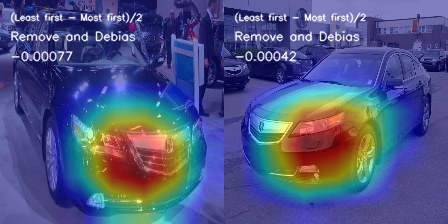

In [340]:
# code de 2 modèles qui se ressemblent avec grad
rl = "/kaggle/input/stanford-car-dataset-by-classes-folder/car_data/car_data/train/Acura RL Sedan 2012/03875.jpg"
tl = "/kaggle/input/stanford-car-dataset-by-classes-folder/car_data/car_data/train/Acura TL Sedan 2012/00002.jpg"

def grad_on_similar_images():
    cam_images = []

    target_layers = [trained_model.layer4]
    targets = [ClassifierOutputTarget(195)]
    metric_targets = [ClassifierOutputSoftmaxTarget(195)]
    
    cam = EigenGradCAM(model=model, target_layers=target_layers)
    cam_metric = ROADCombined(percentiles=[20, 40, 60, 80])
    
    file_names = [rl, tl]
    
    for image_path in file_names:
        img = np.array(Image.open(image_path))
        img = cv2.resize(img, (224, 224))
        img = np.float32(img) / 255

        input_tensor = preprocess_image(img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]).to(device)
        
        attributions = cam(input_tensor=input_tensor, targets=targets)
        scores = cam_metric(input_tensor, attributions, metric_targets, model)
        
        cam_image = show_cam_on_image(img, attributions[0, :], use_rgb=True)
        cam_image = visualize_score(cam_image, scores[0])
        
        cam_images.append(cam_image)

    res = np.hstack(cam_images)
    display(Image.fromarray(res))
    
grad_on_similar_images()

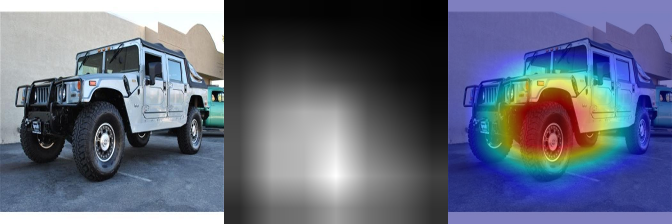

In [345]:
# Black pixel
file = "/kaggle/input/stanford-car-dataset-by-classes-folder/car_data/car_data/train/AM General Hummer SUV 2000/00163.jpg"

target_layers = [trained_model.layer4]
targets = [ClassifierOutputTarget(195)]
metric_targets = [ClassifierOutputSoftmaxTarget(195)]
    
cam = EigenGradCAM(model=model, target_layers=target_layers)
cam_metric = ROADCombined(percentiles=[20, 40, 60, 80])
    
img = np.array(Image.open(file))
img = cv2.resize(img, (224, 224))
img = np.float32(img) / 255

input_tensor = preprocess_image(img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]).to(device)
        
attributions = cam(input_tensor=input_tensor, targets=targets)
        
cam_image = show_cam_on_image(img, attributions[0, :], use_rgb=True)
cam = np.uint8(255*grayscale_cams[0, :])
cam = cv2.merge([cam, cam, cam])
images = np.hstack((np.uint8(255*img), cam , cam_image))
Image.fromarray(images)